Heat transfer of railway brake disc

disc 2 can have heat conduction, which is better than disc 1.

This work, disc 3 use Neumann boundary conditon to input heat flux.

Author: yanjun zhang

# ds needs define correct

## 1: Start

Source from 
book "Abali - 2017 - Computational Reality" P119

In [1]:
import matplotlib.pyplot as plt
import pyvista, ufl, dolfinx, time
import numpy as np
from petsc4py import PETSc
from mpi4py import MPI
from dolfinx.fem.petsc import LinearProblem,assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc
from dolfinx import fem, mesh, io, plot, default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, Function, FunctionSpace, 
                         form,  locate_dofs_topological)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import  locate_entities, locate_entities_boundary,meshtags
from ufl import (SpatialCoordinate, TestFunction, TrialFunction,
                 dx, grad, inner, Measure, dot, jump, FacetNormal, avg, FiniteElement, MixedElement)
from find_com_e import find_common_e

# Start time, Final time ,Time step
t,  Total_time,  num_steps  = 0,  5, 50  
# time step size
dt = Total_time / num_steps  
# initial and brake pad temperature
Ti, Tm =  25, 25
t_u = 1e3 # m to mm
# density (kg.m^-3), capacity (J/Kg.K), conductivity (W/m.K)
rho , c ,k  = 7850 /(t_u**3), 462,  48 / t_u
# mu, P_brake, v_angualr , r_disc , heat_distribution
mu , P_brake , v_angualr , r_disc , heat_distribution = 0.35, 246000, 48.3, 0.25, 0.88
# S_or is the original brake pad rubbing area, 200 cm2. 
S_or, S_new = 200, 200
# g is the heat source,unit is w/mm2
g = mu * P_brake * v_angualr * r_disc * heat_distribution *2 /(t_u**2)  * (S_or/S_new) * 10

print(g)

/home/yanjun/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


18.297971999999998


## 2: Mesh

In [2]:


filename = "3-10" # mesh
domain, cell_markers, facet_markers = gmshio.read_from_msh(filename+".msh", MPI.COMM_WORLD, 0, gdim=3)

# Define variational problem, Here Lagrange changes to CG, what is CG?
V = fem.FunctionSpace(domain, ('CG', 1))
# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs = [])
    return problem.solve()
    
# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V
Q = FunctionSpace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init,V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 50) )
bc = fem.dirichletbc(PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V)

Info    : Reading '3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading '3-10.msh'


## 3: Setup output


In [4]:
xdmf = io.XDMFFile(domain.comm, "temperature4.xdmf", "w")
xdmf.write_mesh(domain)

# Create boundary condition
import sys
sys.path.append('/home/yanjun/Documents/FEniCSx/Tutorial/Mesh/')
from rub_co import get_rub_coordinate
x_co, y_co = get_rub_coordinate()

x = SpatialCoordinate(domain)
boundaries = []
for i, (x_c, y_c) in enumerate(zip(x_co, y_co), start=1):
    vari_name = 10*i
    boundaries.append(  (vari_name, lambda x: (x[0]-x_c)**2 + (x[1]-y_c)**2  <= 324)  )
    
facet_indices, facet_markers = [], []   
fdim = domain.topology.dim - 1  
for (marker, locator) in boundaries:
     facets = locate_entities(domain, fdim, locator)
     facet_indices =(facets)
     facet_markers =(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])
ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 


u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
n = FacetNormal(domain)
class BoundaryCondition():
    def __init__(self, type, marker, values):
        self._type = type
        if type == "Neumann_l":
           self._bc = inner(values, v) * ds(marker)    
        elif type == "Neumann_a":
             self._bc =  -  k * dot( grad(values)* v, n) *ds(marker)
    @property
    def bc(self):
        return self._bc
    @property
    def type(self):
        return self._type
  
# ds tutorial: https://github.com/FEniCS/ufl/blob/main/ufl/measure.py

boundary_conditions_l = []
boundary_conditions_a = []
for i in list(range(1,19)):
    boundary_conditions_l.append ( BoundaryCondition("Neumann_l", 10*i, g)  )
    boundary_conditions_a.append ( BoundaryCondition("Neumann_a", 10*i, u)  )

neumann_l = inner(g, v) *0
neumann_a = inner(g, v) *0

for condition in boundary_conditions_l:
    if condition.type == "Dirichlet":
        bcs.append(condition.bc)
    else:
        neumann_l += condition.bc
        
for condition in boundary_conditions_a:
    if condition.type == "Dirichlet":
        bcs.append(condition.bc)
    else:
        neumann_a += condition.bc

uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init,V)
xdmf.write_function(uh, t)

In [7]:
print(boundaries)

print(ds(10))
print(ds(20))
#print(neumann_l)
#print(neumann_a)

[(10, <function <lambda> at 0x744a500971c0>), (20, <function <lambda> at 0x744a50cfdcf0>), (30, <function <lambda> at 0x744abf616a70>), (40, <function <lambda> at 0x744abf617130>), (50, <function <lambda> at 0x744abf6176d0>), (60, <function <lambda> at 0x744abf617010>), (70, <function <lambda> at 0x744abf617400>), (80, <function <lambda> at 0x744abf616e60>), (90, <function <lambda> at 0x744abf616950>), (100, <function <lambda> at 0x744abf617880>), (110, <function <lambda> at 0x744abf6170a0>), (120, <function <lambda> at 0x744abf617910>), (130, <function <lambda> at 0x744abf6171c0>), (140, <function <lambda> at 0x744a4bf63eb0>), (150, <function <lambda> at 0x744a4bf639a0>), (160, <function <lambda> at 0x744a4bf609d0>), (170, <function <lambda> at 0x744a4bf61e10>), (180, <function <lambda> at 0x744a4bf62200>)]
ds(subdomain_id=10, domain=<Mesh #0>, subdomain_data=<dolfinx.mesh.MeshTags object at 0x744a50d11060>)
ds(subdomain_id=20, domain=<Mesh #0>, subdomain_data=<dolfinx.mesh.MeshTags o

## 4: Variational equation


In [9]:
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n = FacetNormal(domain)

#a = (rho*c)/dt * u * v *dx + k* dot(grad(u), grad(v)) *dx -  k * dot(grad(u)*v, n) *ds(17)
#L = f *v *dx + (rho*c)/dt * u_n * v * dx   +  g  * v *ds(17)
a = (rho*c)/dt * inner(u,v) *dx + k* inner(grad(u), grad(v)) *dx + neumann_a
L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx + neumann_l

#for i in list(range(1,19)):
#     a +=   -  k * dot( grad(u)* v, n) *ds(10*i)
#     L +=   +  inner(g, v) *ds(10*i)

# assembly matrix and vector
bilinear_form = fem.form(a)
linear_form = fem.form(L)

A = assemble_matrix(bilinear_form)
A.assemble()
b = create_vector(linear_form)
## 7: Using petsc4py to create a linear solver
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl
pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()
plotter.open_gif("Temperature_4.gif", fps=30)
grid.point_data["Temperature"] = uh.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20,  color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)
renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            #clim=[0, max(uh.x.array)])
                            clim=[0,  200])

In [10]:
print(L)

{ c_0 * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})
  +  { 0.036266999999999994 * u_n * (conj((v_0))) } * dx(<Mesh #0>[everywhere], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[10], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[20], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[30], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[40], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[50], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[60], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[70], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[80], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[90], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[100], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[110], {})
  +  { 18.297971999999998 * (conj((v_0))) } * ds(<Mesh #0>[120], {})
  +  { 18.297971999999998 * (conj((v_0)))

## 5: Solution


1: Rotation has applied for 5 degree. 2: Current time is 0.1 s. 3: Completion is 2.0 %. 

  warnings.warn(

  warnings.warn(



1: Rotation has applied for 250 degree. 2: Current time is 5.0 s. 3: Completion is 100.0 %. 


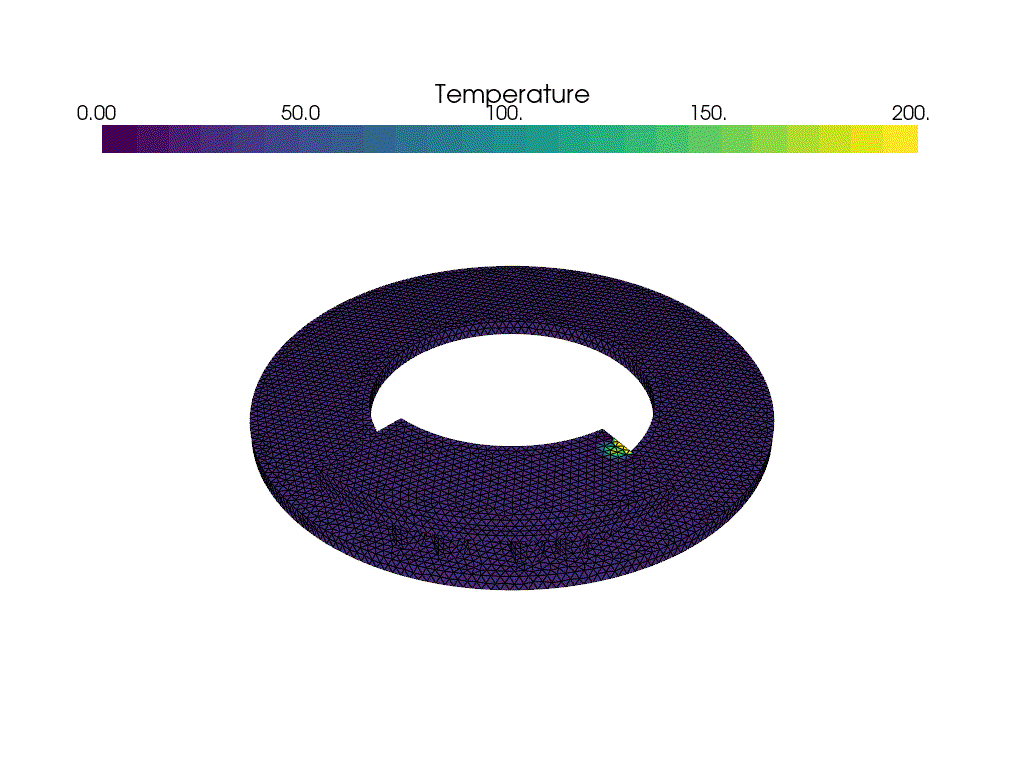

In [11]:
from rotation_co import rub_rotation
import numpy as np

degree = 5
total_degree = 0

for i in range(num_steps):
    t += dt
    x_co, y_co = rub_rotation (x_co, y_co, degree)   # update the location
    total_degree += degree  # Incrementing degree by 10 in each step
    sys.stdout.write('\r1: Rotation has applied for {} degree. '.format(total_degree))
    sys.stdout.write('2: Current time is ' + str(round(t,1)) + " s. ")
    sys.stdout.write('3: Completion is '  + str(round (100*(t/Total_time),1) )+ " %. ")
    sys.stdout.flush()
    
    boundaries = []
    for i, (x_c, y_c) in enumerate(zip(x_co, y_co), start=1):
        vari_name = 10*i
        boundaries.append ( (vari_name, lambda x: (x[0]-x_c)**2 + (x[1]-y_c)**2  <= 324) )
        facet_indices, facet_markers = [], []  
    for (marker, locator) in boundaries:
        facets = locate_entities(domain, fdim, locator)
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tag = meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])
    ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 

    #a = (rho*c)/dt * inner(u,v) *dx + k* inner(grad(u), grad(v)) *dx 
    #L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx
    #for i in list(range(1,19)):
    #    a +=   -  k * dot( grad(u)*v, n) *ds(10*i)
    #    L +=   +  inner(g, v) *ds(10*i)
    u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
    n = FacetNormal(domain)
    class BoundaryCondition():
        def __init__(self, type, marker, values):
            self._type = type
            if type == "Neumann_l":
               self._bc = inner(values, v) * ds(marker)    
            elif type == "Neumann_a":
                 self._bc =  -  k * dot( grad(values)* v, n) *ds(marker)
        @property
        def bc(self):
            return self._bc
        @property
        def type(self):
            return self._type
  
# ds tutorial: https://github.com/FEniCS/ufl/blob/main/ufl/measure.py

    boundary_conditions_l = []
    boundary_conditions_a = []
    for i in list(range(1,19)):
        boundary_conditions_l.append ( BoundaryCondition("Neumann_l", 10*i, g)  )
        boundary_conditions_a.append ( BoundaryCondition("Neumann_a", 10*i, u)  )

    neumann_l = inner(g, v) *0
    neumann_a = inner(g, v) *0

    for condition in boundary_conditions_l:
        if condition.type == "Dirichlet":
            bcs.append(condition.bc)
        else:
            neumann_l += condition.bc
        
    for condition in boundary_conditions_a:
        if condition.type == "Dirichlet":
            bcs.append(condition.bc)
        else:
            neumann_a += condition.bc
   

    a = (rho*c)/dt * inner(u,v) *dx + k* inner(grad(u), grad(v)) *dx + neumann_a
    L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx + neumann_l

    
    #bilinear_form = fem.form(a)
    linear_form = fem.form(L)
    b = create_vector(linear_form)
    A = assemble_matrix(bilinear_form, bcs=[bc])
    A.assemble()
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.PREONLY)
    solver.getPC().setType(PETSc.PC.Type.LU)
    
    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, linear_form)
    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])
    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array
    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    #warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(uh.x.array, render=False)
    plotter.write_frame()
    
plotter.close() 
xdmf.close()
print()

# Display the GIF
from IPython.display import display, Image

display(Image(filename = 'Temperature_4.gif'))

In [8]:
print(L)


NameError: name 'L' is not defined

In [ ]:
print(ds(1))
print(ds(2))


In [ ]:
print(neumann_l)